In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from abtem import Probe, Potential, GridScan, SegmentedDetector, FlexibleAnnularDetector, PixelatedDetector

# Detectors and 4D-STEM

It is particularly easy to describe modern segmented and pixelated detectors used for 4D-STEM in abTEM. Let's start by defining a probe and a scan over a graphene model.

In [2]:
atoms = read('data/orthogonal_graphene.cif') * (2,2,1)

probe = Probe(energy=80e3, semiangle_cutoff=30)

potential = Potential(atoms, sampling=.05, slice_thickness=2)

probe.grid.match(potential)

gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=probe.ctf.nyquist_sampling * .9)

## Segmented detector

The `SegmentedDetector` covers an annular angular range, and is partitioned into several integration regions divided to radial and angular segments whose number is given by the parameters `nbins_radial` and `nbins_angular`. This can be used for simulating differential phase contrast (DPC) imaging. 

In [3]:
dpc_detector = SegmentedDetector(inner=30, outer=100, nbins_radial=4, nbins_azimuthal=4, rotation=np.pi / 8)

(<PolarAxesSubplot:>, <matplotlib.collections.QuadMesh at 0x1dad65b4490>)

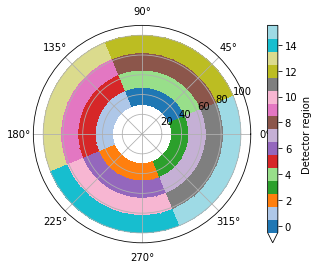

In [4]:
dpc_detector.show()

This detector is divided into eight different integration regions, which we illustrate below.

We then scan our probe over the potential and record the scattering intensity into our segmented detector.

In [6]:
dpc_measurement = probe.scan(gridscan, dpc_detector, potential, compute=True)

The resulting measurement is 4D. The first two dimensions represent the scan dimensions, and the last two represent the radial and angular segments, respectively.

To show the output we need to perform a reduction of the dimension of the data from 4d to 1d or 2d. The simplest reduction is just indexing; below we show the signal from the first scan position.

(0.0, 120.0)

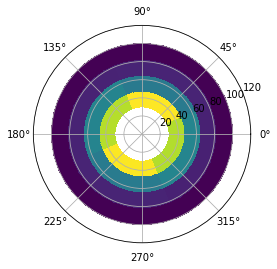

In [7]:
ax, _ = dpc_measurement.show();

ax.set_rlim([0,120])

We may also reduce the dimension by taking the mean. Below we calculate the mean detector signal, which is just an ADF STEM image.

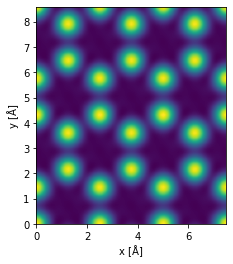

In [8]:
integrated_image = dpc_measurement.integrate(detector_regions=(0, 4, 8, 12)).interpolate(.05)

integrated_image.interpolate(.05).tile((3,2)).show();

To obtain a differential signal, we can subtract the signal from detector regions 2 and 3 from regions 0 and 1.

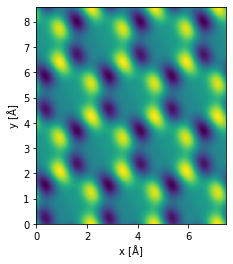

In [9]:
signal_01 = dpc_measurement.integrate(detector_regions=(0,1))

signal_23 = dpc_measurement.integrate(detector_regions=(2,3))

differential_signal = signal_01.subtract(signal_23)

differential_signal.interpolate(.05).tile((3,2)).show();

## Flexible annular detector

The `FlexibleAnnularDetector` allows us to choose the integration limits after running the simulation. Here, we create a detector with a spacing between detector regions of 10 mrad.

In [10]:
flexible_detector = FlexibleAnnularDetector(step_size=5)

Note that the maximum detected scattering angle is limited by the antialiasing aperture.

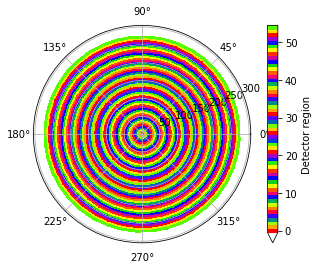

In [11]:
flexible_detector.show(probe);

We can again scan our probe over the potential using this detector.

In [12]:
flexible_measurement = probe.scan(gridscan, flexible_detector, potential).compute()

The resulting measurement data is 3D. The first two dimensions represent the scan dimensions, the last dimension represents the detector bins.

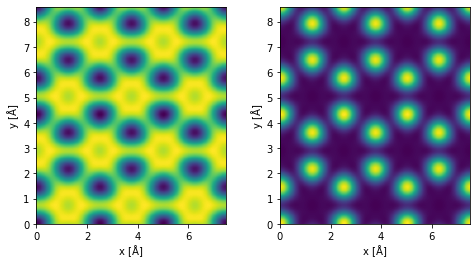

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

flexible_measurement.integrate_radial(0, 30).interpolate(.05).tile((3,2)).show(ax=ax1)
flexible_measurement.integrate_radial(50, 150).interpolate(.05).tile((3,2)).show(ax=ax2);

We can then sample the scattered intensity into a desired angular range (within the spacing resolution determined above). By choosing an angular range corresponding to an ADF detector, we can again recover a typical STEM image.

## Pixelated detector

The `PixelatedDetector` records the intensity of the Fourier-transformed exit wave function, i.e. a complete convergent-beam electron diffraction pattern. Hence, a 2D scan with this detector results in a large four-dimensional dataset (a 2D diffraction pattern recorded at every 2D probe position). The 4D datasets thus generated can be used to reconstruct the results of any of the other detector geometries, hence the only downside of using this detector is the high memory or disk space requirements of storing the data.

In [39]:
pixelated_detector = PixelatedDetector(max_angle=100)

In [42]:
pixelated_measurements = probe.scan(gridscan, pixelated_detector, potential, compute=False)

In [43]:
pixelated_measurements.array

dask.array<_diffraction_pattern, shape=(8, 14, 73, 83), dtype=float32, chunksize=(8, 12, 73, 83), chunktype=numpy.ndarray>

In [38]:
pixelated_measurements.angular_sampling

(2.829075919030735, 2.4500516074213947)

Indexing the scan dimensions returns a single diffraction pattern.

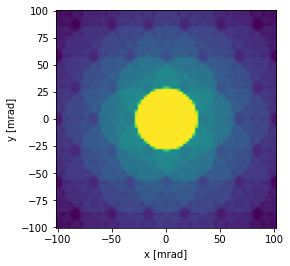

In [16]:
pixelated_measurements.show(power=.001);

As an example, we can use these measurements to generate center-of-mass images.

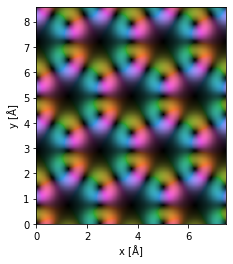

In [37]:
com = pixelated_measurements.center_of_mass()

com.interpolate(.05).tile((3,2)).show();